Connect Database successfully


C:\Users\My PC\AppData\Local\Temp/ipykernel_9764/1761735668.py:20: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



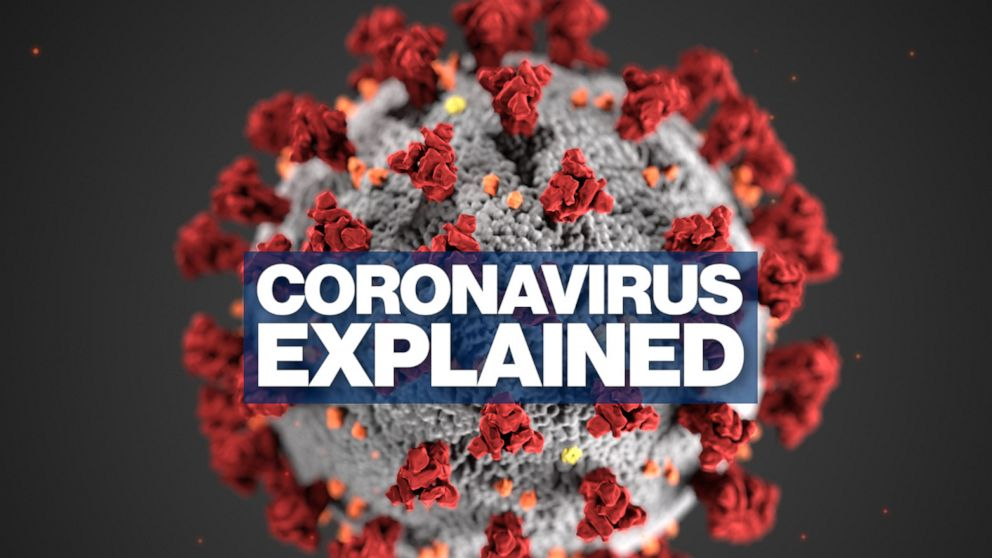

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import os
# for offline ploting
from plotly.offline import plot
import pandas as pd 
import math
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from connect_mysql import query
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings('ignore')
WORKING_PATH = os.getcwd()
from IPython.display import Image
Image(filename = rf'{WORKING_PATH}\data\covid.jpg')

In [2]:
PLOT_SIZE = (16, 10)
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
updated_date = (datetime.datetime.today()-datetime.timedelta(days=2)).strftime('%m-%d-%Y')
latest_data = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{updated_date}.csv')
sum_country = query(keyw='Read', table_name='SUMMARY_COVID_DATA')[['NAME', 'CONTINENT', 'TOTAL_CASES', 'TOTAL_DEATHS', 'TOTAL_RECOVERED', 'ACTIVE_CASES', 'SERIOUS_CRITICAL', 'FATALITY_RATE']] ### query from database and get specified columns

In [ ]:
df_continents_cases = sum_country[['CONTINENT', 'TOTAL_CASES', 'TOTAL_DEATHS', 'TOTAL_RECOVERED', 'ACTIVE_CASES', 'SERIOUS_CRITICAL']]
df_continents_cases = df_continents_cases.groupby(by='CONTINENT').sum()

In [ ]:
### gradient table of continents about confirmed, deaths, ...
df_continents_cases['FATALITY_RATE (per 100)'] = np.round(100*df_continents_cases['TOTAL_DEATHS']/df_continents_cases['TOTAL_CASES'],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=['TOTAL_CASES'])\
                        .background_gradient(cmap='Reds',subset=['TOTAL_DEATHS'])\
                        .background_gradient(cmap='Greens',subset=['TOTAL_RECOVERED'])\
                        .background_gradient(cmap='Purples',subset=['ACTIVE_CASES'])\
                        .background_gradient(cmap='Pastel1_r',subset=['SERIOUS_CRITICAL'])\
                        .background_gradient(cmap='YlOrBr',subset=['FATALITY_RATE (per 100)'])\
                        .format('{:.2f}')\
                        .format('{:.0f}',subset=['TOTAL_CASES','TOTAL_DEATHS','TOTAL_RECOVERED','ACTIVE_CASES', 'SERIOUS_CRITICAL'])

In [ ]:
### top 30 country with gradient table
sum_country.drop(['CONTINENT'], axis=1).sort_values('TOTAL_CASES', ascending= False).head(30).set_index(['NAME']).style.background_gradient(cmap='Blues',subset=['TOTAL_CASES'])\
                        .background_gradient(cmap='Reds',subset=['TOTAL_DEATHS'])\
                        .background_gradient(cmap='Greens',subset=['TOTAL_RECOVERED'])\
                        .background_gradient(cmap='Purples',subset=['ACTIVE_CASES'])\
                        .background_gradient(cmap='Pastel1_r',subset=['SERIOUS_CRITICAL'])\
                        .background_gradient(cmap='YlOrBr',subset=['FATALITY_RATE'])\
                        .format('{:.2f}')\
                        .format('{:.0f}',subset=['TOTAL_CASES','TOTAL_DEATHS','TOTAL_RECOVERED','ACTIVE_CASES', 'SERIOUS_CRITICAL'])

In [ ]:
### function for reformating and generating csv file for running bar chart
def convert_df_running(origin_df, csv_name):
    df_running = origin_df.drop(['Lat', 'Long'], axis=1)
    df_running.columns = df_running.columns.str.replace('/', '-')
    df_running = df_running.groupby(by='Country-Region').sum()
    df_running.to_csv(rf'D:\PycharmProjects\Python\Covid-19\data\{csv_name}.csv')
convert_df_running(confirmed_df, 'confirmed_running')
convert_df_running(deaths_df, 'deaths_running')

In [ ]:
### create a plot map to show about the confirmed, deaths and recovered status
def plot_map(df, col):
    df = df[df[col]>0]
    fig = px.choropleth(df, locations='NAME', locationmode='country names', 
                  color=col, hover_name='NAME', 
                  title=col, hover_data=[col], color_continuous_scale='matter')                
    fig.show()

In [ ]:
plot_map(sum_country, 'TOTAL_CASES')
plot_map(sum_country, 'TOTAL_DEATHS')
plot_map(sum_country, 'TOTAL_RECOVERED')

In [ ]:
### scatter plot with for top 20 country with total deaths and total cases 
fig = px.scatter(sum_country.sort_values('TOTAL_DEATHS', ascending=False).iloc[:20, :], 
                 x='TOTAL_CASES', y='TOTAL_DEATHS', color='NAME', size='TOTAL_CASES', 
                 height=700, text='NAME', log_x=True, log_y=True, 
                 title='Deaths vs Confirmed')
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [ ]:
### reformat for animation map
def convert_df_animation(origin_df, col):
    df_converted = origin_df.drop(['Lat', 'Long', 'Province/State'], axis=1) 
    df_converted = df_converted.set_index(['Country/Region']).stack().reset_index().rename(columns={'level_1':'Date', 0: col}) ### convert column dates to rows and rename
    df_converted['Date'] = df_converted['Date'].astype('datetime64[ns]')
    df_converted = df_converted.sort_values(by=['Date', 'Country/Region']) 
    return df_converted

In [ ]:
confirmed_df_converted = convert_df_animation(confirmed_df, 'Total_Confirmed')
deaths_df_converted = convert_df_animation(deaths_df, 'Total_Deaths')

In [ ]:
### merge detail confirmed_gb and deaths_gb df and update to database
confirmed_df_converted_gb = confirmed_df_converted.groupby(by=['Country/Region', 'Date']).sum().reset_index().sort_values(by=['Date', 'Country/Region']) 
deaths_df_converted_gb = deaths_df_converted.groupby(by=['Country/Region', 'Date']).sum().reset_index().sort_values(by=['Date', 'Country/Region']) 
detail_df = pd.merge(confirmed_df_converted_gb, deaths_df_converted_gb, left_index=True, right_index=True)
detail_df = detail_df[['Country/Region_x', 'Date_x', 'Total_Confirmed', 'Total_Deaths']]
rows = [tuple(row) for row in detail_df.values]
query(keyw='Truncate', table_name='DETAIL_COVID_DATA')
query(keyw='Insert', table_name='DETAIL_COVID_DATA', num_cols=4, data_arr=rows)

In [ ]:
### animation map for cases over time and open a html file
fig = px.choropleth(confirmed_df_converted, locations='Country/Region', 
                    color=np.log(confirmed_df_converted['Total_Confirmed']),
                    locationmode='country names', hover_name='Country/Region', 
                    animation_frame=confirmed_df_converted['Date'].dt.strftime('%Y-%m-%d'),
                    title='Cases over time', color_continuous_scale=px.colors.sequential.matter)
fig.update(layout_coloraxis_showscale=False)
plot(fig)

In [ ]:
### animation map for deaths over time and open a html file
fig = px.choropleth(deaths_df_converted, locations='Country/Region', 
                    color=np.log(deaths_df_converted['Total_Deaths']),
                    locationmode='country names', hover_name='Country/Region', 
                    animation_frame=deaths_df_converted['Date'].dt.strftime('%Y-%m-%d'),
                    title='Deaths over time', color_continuous_scale=px.colors.sequential.matter)
fig.update(layout_coloraxis_showscale=False)
plot(fig)

In [3]:
cols = confirmed_df.keys()
### get data from 22/1/2021 to updated_date
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]] 
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
dates = confirmed.keys() ### get list of date
total_cases = []
total_deaths = [] 
mortality_rate = []
for day in dates:
    confirmed_sum = confirmed[day].sum()
    death_sum = deaths[day].sum()
    
    # confirmed, deaths
    total_cases.append(confirmed_sum) ### total cases day by day
    total_deaths.append(death_sum) ### total deaths day by day
    
    # calculate mortality rates
    mortality_rate.append(death_sum/confirmed_sum) ### mortality rates day by day

In [4]:
### get the list of daily increase
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 
### list of moving average
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(total_cases)
world_confirmed_avg = moving_average(total_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

In [16]:
num_of_days = np.array([i for i in range(len(dates))]) ### since 22/1/2020
total_cases = np.array(total_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

In [ ]:
### line plot for world cases and moving average 
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_cases, linewidth=4.5)
plt.plot(num_of_days, world_confirmed_avg, linestyle='dashed', color='red', linewidth=4.5)
plt.title('Total of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### line plot for death cases and moving average 
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_deaths, linewidth=4.5)
plt.plot(num_of_days, world_death_avg, linestyle='dashed', color='red', linewidth=4.5)
plt.title('Total of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
### bar plot for daily world cases and line plot moving average 
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, world_daily_increase)
plt.plot(num_of_days, world_daily_increase_avg, color='red', linestyle='dashed', linewidth=4.5)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### bar plot for daily world cases and line plot moving average 
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, world_daily_death)
plt.plot(num_of_days, world_daily_death_avg, color='red', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
def country_plot(x, y1, y2, y3, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)

    plt.figure(figsize=PLOT_SIZE)
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=PLOT_SIZE)
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=PLOT_SIZE)
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [ ]:
# helper function for getting country's cases and deaths       
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    for day in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][day].sum()) ### list of total cases day by day of country(cumsum)
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][day].sum()) ### list of total deaths day by day of country(cumsum)
    return (country_cases, country_deaths)

In [ ]:
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    
    country_daily_increase = daily_increase(country_cases) ### list of daily confirmed cases of country
    country_daily_death = daily_increase(country_deaths) ### list of daily deaths of country
    country_plot(num_of_days, country_cases, country_daily_increase, country_daily_death, country_name)

In [ ]:
country_visualizations(input('Which country do you want to see: '))

In [ ]:
unique_countries = list(latest_data['Country_Region'].unique()) ### get list of unique country
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 
no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases) ### list country has cases
    else:
        no_cases.append(i) ### list country has no cases
        
for i in no_cases:
    unique_countries.remove(i) ### final list country has cases
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [ ]:
### gradient table of all country with confirmed cases, deaths, incident and mortality rate
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in country_confirmed_cases],
                          'Number of Deaths': [format(int(i), ',d') for i in country_death_cases], 
                          'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
                          
### number of cases per country/region
country_df.style.background_gradient(cmap='autumn_r')

In [ ]:
### plot with mean and day by day mortality rate of World
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, mortality_rate, color='red', lw=3.5)
plt.axhline(y = mean_mortality_rate, linestyle='--', color='black', lw=3.5)
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.legend(['Mean_mortality_rate', 'Worldwide Mortality Rate'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
unique_provinces =  list(latest_data['Province_State'].unique()) ### get list of unique province
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_incidence_rate = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i) ### final list province has cases
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_incidence_rate.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Incident_Rate'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [ ]:
# number of cases per province/state/city top 100 
province_limit = 100 
province_df = pd.DataFrame({'Province/State Name': unique_provinces[:province_limit], 'Country': province_country[:province_limit], 'Number of Confirmed Cases': [format(int(i), ',d') for i in province_confirmed_cases[:province_limit]],
                          'Number of Deaths': [format(int(i), ',d') for i in province_death_cases[:province_limit]], 
                        'Incidence Rate' : province_incidence_rate[:province_limit], 'Mortality Rate': province_mortality_rate[:province_limit]})

# gradient table displays number of cases per country/region
province_df.style.background_gradient(cmap='Oranges')

In [ ]:
# return the data table with province/state info for a given country
def country_table(country_name):
    states = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    state_confirmed_cases = []
    state_death_cases = [] 
    state_incidence_rate = [] 
    state_mortality_rate = [] 

    no_cases = [] 
    for i in states:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            state_confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        state_confirmed_cases[i] = latest_data[latest_data['Province_State']==states[i]]['Confirmed'].sum()
        state_death_cases.append(latest_data[latest_data['Province_State']==states[i]]['Deaths'].sum())
        state_incidence_rate.append(latest_data[latest_data['Province_State']==states[i]]['Incident_Rate'].sum())
        state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in state_confirmed_cases],
                              'Number of Deaths': [format(int(i), ',d') for i in state_death_cases], 
                             'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
    # number of cases per country/region
    return state_df

In [ ]:
### gradient table of states of chosen country
table = country_table(input('Choose your country which you want to see its states: '))
table.style.background_gradient(cmap='Oranges')

In [ ]:
### bar chart to compare confirmed cases and percentage with others
total_world_cases = np.sum(country_confirmed_cases)
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = total_world_cases - us_confirmed

plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed/total_world_cases)
plt.barh('Outside United States', outside_us_confirmed/total_world_cases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print('Outside United States {} cases ({}%):'.format(outside_us_confirmed, np.round((outside_us_confirmed/total_world_cases)*100, 1)))
print('United States {} cases ({}%)'.format(us_confirmed, np.round((us_confirmed/total_world_cases)*100, 1)))
print('Total: {} cases'.format(total_world_cases))

In [ ]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others') ### list of country top 10 and others
visual_confirmed_cases.append(others) ### list of confirmed cases of top 10 country and others

In [ ]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=PLOT_SIZE)
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [ ]:
### bar chart for top 10 country and the rest
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

In [ ]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

In [ ]:
### bar chart for top 10 province and the rest
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

In [ ]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c, shadow=True)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

In [ ]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')
plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases per State/Province/Region')

In [ ]:
# Plotting countries with regional data using a pie chart 
def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered 'others'    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5, confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

In [ ]:
country_name = input('Choose the country name: ')
plot_pie_country_with_regions(country_name, f'Covid-19 Confirmed Cases in {country_name}')

### flourish running bar chart
https://public.flourish.studio/visualisation/7725160/
https://public.flourish.studio/visualisation/7731310/

In [ ]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [ ]:
days_to_skip = 376
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], total_cases[days_to_skip:], test_size=0.08, shuffle=False) 

In [ ]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

In [ ]:
len(svm_pred)

COMPARE BETWEEN ASIA AND VIETNAM OVER CORONAVIRUS TIME

In [5]:
### merge and validate confirmed_df with continent
def merge_continent(df):
    df_continent = pd.merge(left=df, right=sum_country[['NAME', 'CONTINENT']], left_on='Country/Region', right_on='NAME', how='left').drop(columns='NAME')
    df_continent = df_continent.set_index('Country/Region')
    df_continent.loc[['Burma', 'Korea, South', 'United Arab Emirates', 'Taiwan*'], 'CONTINENT'] = 'Asia'
    df_continent.loc[['Central African Republic', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire"], 'CONTINENT'] = 'Africa'
    df_continent.loc['US', 'CONTINENT'] = 'North America'
    df_continent.loc[['Palau', 'Samoa', 'Micronesia', 'Tonga'], 'CONTINENT'] = 'Australia/Oceania'
    df_continent.loc[['United Kingdom', 'Kosovo', 'Holy See'], 'CONTINENT'] = 'Europe'
    df_continent.loc[['Kiribati', 'MS Zaandam', 'Summer Olympics 2020', 'Diamond Princess', 'Saint Vincent and the Grenadines', 'West Bank and Gaza'], 'CONTINENT'] = 'Unknown'
    df_continent.reset_index(inplace=True)
    return df_continent

In [6]:
confirmed_df_continent = merge_continent(confirmed_df)
confirmed_df_asia = confirmed_df_continent[confirmed_df_continent['CONTINENT']=='Asia']
deaths_df_continent = merge_continent(deaths_df)
deaths_df_asia = deaths_df_continent[deaths_df_continent['CONTINENT']=='Asia']

In [ ]:
total_cases_asia = []
total_deaths_asia = [] 
mortality_rate_asia = []
for day in dates:
    confirmed_sum_asia = confirmed_df_asia[day].sum()
    deaths_sum_asia = deaths_df_asia[day].sum()
    
    # confirmed, deaths
    total_cases_asia.append(confirmed_sum_asia) ### total cases day by day
    total_deaths_asia.append(deaths_sum_asia) ### total deaths day by day
    
    # calculate mortality rates
    mortality_rate_asia.append(deaths_sum_asia/confirmed_sum_asia) ### mortality rates day by day

In [15]:
confirmed_df_vietnam = confirmed_df_asia[confirmed_df_asia['Country/Region']=='Vietnam']
deaths_df_vietnam = deaths_df_asia[deaths_df_asia['Country/Region']=='Vietnam']
total_cases_vietnam = []
total_deaths_vietnam = [] 
mortality_rate_vietnam = []
for day in dates:
    confirmed_sum_vietnam = confirmed_df_vietnam[day].sum()
    deaths_sum_vietnam = deaths_df_vietnam[day].sum()
    
    # confirmed, deaths
    total_cases_vietnam.append(confirmed_sum_vietnam) ### total cases day by day
    total_deaths_vietnam.append(deaths_sum_vietnam) ### total deaths day by day
    
    # calculate mortality rates
    mortality_rate_vietnam.append(deaths_sum_vietnam/confirmed_sum_vietnam) ### mortality rates day by day

In [ ]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, mortality_rate_asia, color='red', lw=3.5)
plt.plot(num_of_days, mortality_rate_vietnam, color='blue', lw=3.5)
plt.title('Asia and Vietnam Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.legend(['Asia', 'Vietnam'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# asia confirmed cases
asia_daily_increase = daily_increase(total_cases_asia)
asia_confirmed_avg = moving_average(total_cases_asia, window)
asia_daily_increase_avg = moving_average(asia_daily_increase, window)

# asia deaths cases
asia_daily_death = daily_increase(total_deaths_asia)
asia_death_avg = moving_average(total_deaths_asia, window)
asia_daily_death_avg = moving_average(asia_daily_death, window)

# vietnam confirmed cases
vietnam_daily_increase = daily_increase(total_cases_vietnam)
vietnam_confirmed_avg = moving_average(total_cases_vietnam, window)
vietnam_daily_increase_avg = moving_average(vietnam_daily_increase, window)

# vietnam deaths cases
vietnam_daily_death = daily_increase(total_deaths_vietnam)
vietnam_death_avg = moving_average(total_deaths_vietnam, window)
vietnam_daily_death_avg = moving_average(vietnam_daily_death, window)

In [ ]:
### line plot for confirmed cases and moving average of asia
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_cases_asia, linewidth=4.5)
plt.plot(num_of_days, asia_confirmed_avg, linestyle='dashed', color='red', linewidth=4.5)
plt.title('Total of Coronavirus Confirmed Over Time in Asia', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Asia Coronavirus Confirmed', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### line plot for death cases and moving average of asia
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_deaths_asia, linewidth=4.5)
plt.plot(num_of_days, asia_death_avg, linestyle='dashed', color='red', linewidth=4.5)
plt.title('Total of Coronavirus Deaths Over Time in Asia', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Asia Coronavirus Death', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
### bar plot for daily asia cases and line plot moving average 
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, asia_daily_increase)
plt.plot(num_of_days, asia_daily_increase_avg, color='red', linestyle='dashed', linewidth=4.5)
plt.title('Asia Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'Asia Daily Increase in COVID-19 Cases'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### bar plot for daily asia cases and line plot moving average 
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, asia_daily_death)
plt.plot(num_of_days, asia_daily_death_avg, color='red', linestyle='dashed', linewidth=4.5)
plt.title('Asia Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'Asia Daily Increase in COVID-19 Deaths'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
### compare total confirmed and deaths cases between asia and vietnam 
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_cases_vietnam, linewidth=4.5)
plt.plot(num_of_days, total_cases_asia, color='red', linewidth=4.5)
plt.title('Confirmed Cases Over Time Between Asia and Vietnam', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Vietnam', 'Asia'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_deaths_vietnam, linewidth=4.5)
plt.plot(num_of_days, total_deaths_asia, color='red', linewidth=4.5)
plt.title('Deaths Cases Over Time Between Asia and Vietnam', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Vietnam', 'Asia'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_cases_vietnam, linewidth=4.5)
plt.plot(num_of_days, total_deaths_vietnam, color='red', linewidth=4.5)
plt.title('Confirmed and Deaths Cases Over Time of Vietnam', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Deaths Cases'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [54]:
### list of 6 country in asia has most confirmed cases
top6_country_asia = sum_country[sum_country['CONTINENT']=='Asia'].sort_values(by='TOTAL_CASES', ascending=False).head(6)['NAME'].to_list()
def get_info_country_asia(country):
    confirmed_df = confirmed_df_asia[confirmed_df_asia['Country/Region']==country]
    deaths_df = deaths_df_asia[deaths_df_asia['Country/Region']==country]
    total_cases = []
    total_deaths = [] 
    mortality_rate = []
    for day in dates:
        confirmed_sum = confirmed_df[day].sum()
        deaths_sum = deaths_df[day].sum()
        
        # confirmed, deaths
        total_cases.append(confirmed_sum) ### total cases day by day
        total_deaths.append(deaths_sum) ### total deaths day by day
        
        # calculate mortality rates
        mortality_rate.append(deaths_sum/confirmed_sum) ### mortality rates day by day
    return (total_cases, total_deaths, mortality_rate)
    
dict_top6_asia = {}
for x,y in enumerate(top6_country_asia, 1):
    info = get_info_country_asia(y)
    dict_top6_asia[f'top {x}'] = info

In [ ]:
colors = ['red', 'green', 'purple', 'brown', 'gray', 'black']
plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_top6_asia.values(), colors):
    plt.plot(num_of_days, item[0], color=color, linewidth=4.5)
plt.plot(num_of_days, total_cases_vietnam, linewidth=4.5)
plt.title('Vietnam and Top 6 Country with Confirmed Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(top6_country_asia+['Vietnam'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

colors = ['red', 'green', 'purple', 'brown', 'gray', 'black']
plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_top6_asia.values(), colors):
    plt.plot(num_of_days, item[1], color=color, linewidth=4.5)
plt.plot(num_of_days, total_deaths_vietnam, linewidth=4.5)
plt.title('Vietnam and Top 6 Country with Deaths Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(top6_country_asia+['Vietnam'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

colors = ['red', 'green', 'purple', 'brown', 'gray', 'black']
plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_top6_asia.values(), colors):
    plt.plot(num_of_days, item[2], color=color, linewidth=4.5)
plt.plot(num_of_days, mortality_rate_vietnam, linewidth=4.5)
plt.title('Vietnam and Top 6 Country with Mortality Rate', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(top6_country_asia+['Vietnam'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [27]:
total_asia_confirmed = sum_country[sum_country['CONTINENT']=='Asia']['TOTAL_CASES'].sum()
total_asia_deaths = sum_country[sum_country['CONTINENT']=='Asia']['TOTAL_DEATHS'].sum()
total_asia_recovered = sum_country[sum_country['CONTINENT']=='Asia']['TOTAL_RECOVERED'].sum()
vnam_confirmed = sum_country[sum_country['NAME']=='Vietnam']['TOTAL_CASES'].sum()
vnam_deaths = sum_country[sum_country['NAME']=='Vietnam']['TOTAL_DEATHS'].sum()
vnam_recovered = sum_country[sum_country['NAME']=='Vietnam']['TOTAL_RECOVERED'].sum()
outside_vnam_confirmed = total_asia_confirmed - vnam_confirmed
outside_vnam_deaths = total_asia_deaths - vnam_deaths
outside_vnam_recovered = total_asia_recovered - vnam_recovered

In [ ]:
### bar chart to compare confirmed cases and percentage with the rest in asia
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_confirmed)
plt.barh('Outside Vietnam', outside_vnam_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases in Asia', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_confirmed/total_asia_confirmed)
plt.barh('Outside Vietnam', outside_vnam_confirmed/total_asia_confirmed)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_confirmed, np.round((outside_vnam_confirmed/total_asia_confirmed)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_confirmed, np.round((vnam_confirmed/total_asia_confirmed)*100, 1)))
print('Total: {} cases'.format(total_asia_confirmed))

In [ ]:
### bar chart to compare deaths cases and percentage with the rest in asia
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_deaths)
plt.barh('Outside Vietnam', outside_vnam_deaths)
plt.title('# of Total Coronavirus Deaths Cases in Asia', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_deaths/total_asia_deaths)
plt.barh('Outside Vietnam', outside_vnam_deaths/total_asia_deaths)
plt.title('# of Coronavirus Deaths Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_deaths, np.round((outside_vnam_deaths/total_asia_deaths)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_deaths, np.round((vnam_deaths/total_asia_deaths)*100, 1)))
print('Total: {} cases'.format(total_asia_deaths))

In [ ]:
### bar chart to compare recovered cases and percentage with the rest in asia
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_recovered)
plt.barh('Outside Vietnam', outside_vnam_recovered)
plt.title('# of Total Coronavirus Recovered Cases in Asia', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_recovered/total_asia_recovered)
plt.barh('Outside Vietnam', outside_vnam_recovered/total_asia_recovered)
plt.title('# of Coronavirus Recovered Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_recovered, np.round((outside_vnam_recovered/total_asia_recovered)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_recovered, np.round((vnam_recovered/total_asia_recovered)*100, 1)))
print('Total: {} cases'.format(total_asia_recovered))

In [ ]:
sum_country_asia = {}
for country in top6_country_asia+['Vietnam']:
    cases = sum_country[sum_country['NAME']==country]['TOTAL_CASES'].values[0]
    deaths = sum_country[sum_country['NAME']==country]['TOTAL_DEATHS'].values[0]
    recovered = sum_country[sum_country['NAME']==country]['TOTAL_RECOVERED'].values[0]
    sum_country_asia[country] = [cases, deaths, recovered]

### 3 bar chart to compare top 6 asia and vietnam in total case, deaths and recovered
plt.figure(figsize=(16, 9))
for key, item in sum_country_asia.items():
    plt.bar(key, item[0])
plt.title('# of Total Coronavirus Confirmed Cases of Top 6 Asia and Vietnam', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
for key, item in sum_country_asia.items():
    plt.bar(key, item[1])
plt.title('# of Total Coronavirus Deaths Cases of Top 6 Asia and Vietnam', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
for key, item in sum_country_asia.items():
    plt.bar(key, item[2])
plt.title('# of Total Coronavirus Recovered Cases of Top 6 Asia and Vietnam', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
sum_cases_asia = [item[0] for key, item in sum_country_asia.items()]
sum_deaths_asia = [item[1] for key, item in sum_country_asia.items()]
sum_recovered_asia = [item[2] for key, item in sum_country_asia.items()]

plt.figure(figsize=PLOT_SIZE)
plt.pie(sum_cases_asia, autopct= '%1.1f%%', shadow=True)
plt.legend(top6_country_asia+['Vietnam'], loc='best', fontsize=12)
plt.title('Covid-19 Total Confirmed in Top 6 Asia and Vietnam')

plt.figure(figsize=PLOT_SIZE)
plt.pie(sum_deaths_asia, autopct= '%1.1f%%', shadow=True)
plt.legend(top6_country_asia+['Vietnam'], loc='best', fontsize=12)
plt.title('Covid-19 Total Deaths in Top 6 Asia and Vietnam')

plt.figure(figsize=PLOT_SIZE)
plt.pie(sum_recovered_asia, autopct= '%1.1f%%', shadow=True)
plt.legend(top6_country_asia+['Vietnam'], loc='best', fontsize=12)
plt.title('Covid-19 Total Recovered in Top 6 Asia and Vietnam')
plt.show()

In [23]:
### list of sea countries
sea_countries = ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar','Philippines', 'Singapore', 'Thailand', 'Timor-Leste', 'Vietnam']
confirmed_df_sea = confirmed_df_asia[confirmed_df_asia['Country/Region'].isin(sea_countries)]
deaths_df_sea = deaths_df_asia[confirmed_df_asia['Country/Region'].isin(sea_countries)]

In [24]:
total_cases_sea = []
total_deaths_sea = [] 
mortality_rate_sea = []
for day in dates:
    confirmed_sum_sea = confirmed_df_sea[day].sum()
    deaths_sum_sea = deaths_df_sea[day].sum()
    
    # confirmed, deaths
    total_cases_sea.append(confirmed_sum_sea) ### total cases day by day
    total_deaths_sea.append(deaths_sum_sea) ### total deaths day by day
    
    # calculate mortality rates
    mortality_rate_sea.append(deaths_sum_sea/confirmed_sum_sea) ### mortality rates day by day

In [ ]:
### compare total confirmed and deaths cases between asia and vietnam 
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_cases_vietnam, linewidth=4.5)
plt.plot(num_of_days, total_cases_sea, color='red', linewidth=4.5)
plt.title('Confirmed Cases Over Time Between SEA and Vietnam', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Vietnam', 'SEA'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_deaths_vietnam, linewidth=4.5)
plt.plot(num_of_days, total_deaths_sea, color='red', linewidth=4.5)
plt.title('Deaths Cases Over Time Between SEA and Vietnam', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Vietnam', 'SEA'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [28]:
total_sea_confirmed = sum_country[sum_country['NAME'].isin(sea_countries)]['TOTAL_CASES'].sum()
total_sea_deaths = sum_country[sum_country['NAME'].isin(sea_countries)]['TOTAL_DEATHS'].sum()
total_sea_recovered = sum_country[sum_country['NAME'].isin(sea_countries)]['TOTAL_RECOVERED'].sum()
outside_vnam_confirmed_sea = total_sea_confirmed - vnam_confirmed
outside_vnam_deaths_sea = total_sea_deaths - vnam_deaths
outside_vnam_recovered_sea = total_sea_recovered - vnam_recovered

In [ ]:
### bar chart to compare confirmed cases and percentage with the rest in SEA
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_confirmed)
plt.barh('Outside Vietnam', outside_vnam_confirmed_sea)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_confirmed/total_sea_confirmed)
plt.barh('Outside Vietnam', outside_vnam_confirmed_sea/total_sea_confirmed)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_confirmed_sea, np.round((outside_vnam_confirmed_sea/total_sea_confirmed)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_confirmed, np.round((vnam_confirmed/total_sea_confirmed)*100, 1)))
print('Total: {} cases'.format(total_sea_confirmed))

In [ ]:
### bar chart to compare deaths cases and percentage with the rest in SEA
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_deaths)
plt.barh('Outside Vietnam', outside_vnam_deaths_sea)
plt.title('# of Total Coronavirus Deaths Cases in SEA', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_deaths/total_asia_deaths)
plt.barh('Outside Vietnam', outside_vnam_deaths_sea/total_sea_deaths)
plt.title('# of Coronavirus Deaths Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_deaths_sea, np.round((outside_vnam_deaths_sea/total_sea_deaths)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_deaths, np.round((vnam_deaths/total_sea_deaths)*100, 1)))
print('Total: {} cases'.format(total_sea_deaths))

In [ ]:
## bar chart to compare recovered cases and percentage with the rest in SEA
plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_recovered)
plt.barh('Outside Vietnam', outside_vnam_recovered_sea)
plt.title('# of Total Coronavirus Recovered Cases in SEA', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('Vietnam', vnam_recovered/total_sea_recovered)
plt.barh('Outside Vietnam', outside_vnam_recovered_sea/total_sea_recovered)
plt.title('# of Coronavirus Recovered Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

print('Outside Vietnam {} cases ({}%):'.format(outside_vnam_recovered_sea, np.round((outside_vnam_recovered_sea/total_sea_recovered)*100, 1)))
print('Vietnam {} cases ({}%)'.format(vnam_recovered, np.round((vnam_recovered/total_sea_recovered)*100, 1)))
print('Total: {} cases'.format(total_asia_recovered))

In [51]:
def get_info_country_asia(country):
    confirmed_df = confirmed_df_asia[confirmed_df_asia['Country/Region']==country]
    deaths_df = deaths_df_asia[deaths_df_asia['Country/Region']==country]
    if len(confirmed_df) > 0 and len(deaths_df) > 0:
        total_cases = []
        total_deaths = [] 
        mortality_rate = []
        for day in dates:
            confirmed_sum = confirmed_df[day].sum()
            deaths_sum = deaths_df[day].sum()
            
            # confirmed, deaths
            total_cases.append(confirmed_sum) ### total cases day by day
            total_deaths.append(deaths_sum) ### total deaths day by day
            
            # calculate mortality rates
            mortality_rate.append(deaths_sum/confirmed_sum) ### mortality rates day by day
        return (total_cases, total_deaths, mortality_rate)

dict_sea = {}
for country in sea_countries:
    info = get_info_country_asia(country)
    if info != None:
        dict_sea[country] = info

In [ ]:
colors = ['red', 'green', 'purple', 'brown', 'blue', 'gray', 'black', 'magenta', 'cyan', 'orange']
plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_sea.values(), colors):
    plt.plot(num_of_days, item[0], color=color, linewidth=4.5)
plt.title('SEA with Confirmed Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(dict_sea.keys(), prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_sea.values(), colors):
    plt.plot(num_of_days, item[1], color=color, linewidth=4.5)
plt.title('SEA with Deaths Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(dict_sea.keys(), prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


plt.figure(figsize=PLOT_SIZE)
for item, color in zip(dict_sea.values(), colors):

    plt.plot(num_of_days, item[2], color=color, linewidth=4.5)
plt.title('SEA with Mortality Rate', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(dict_sea.keys(), prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

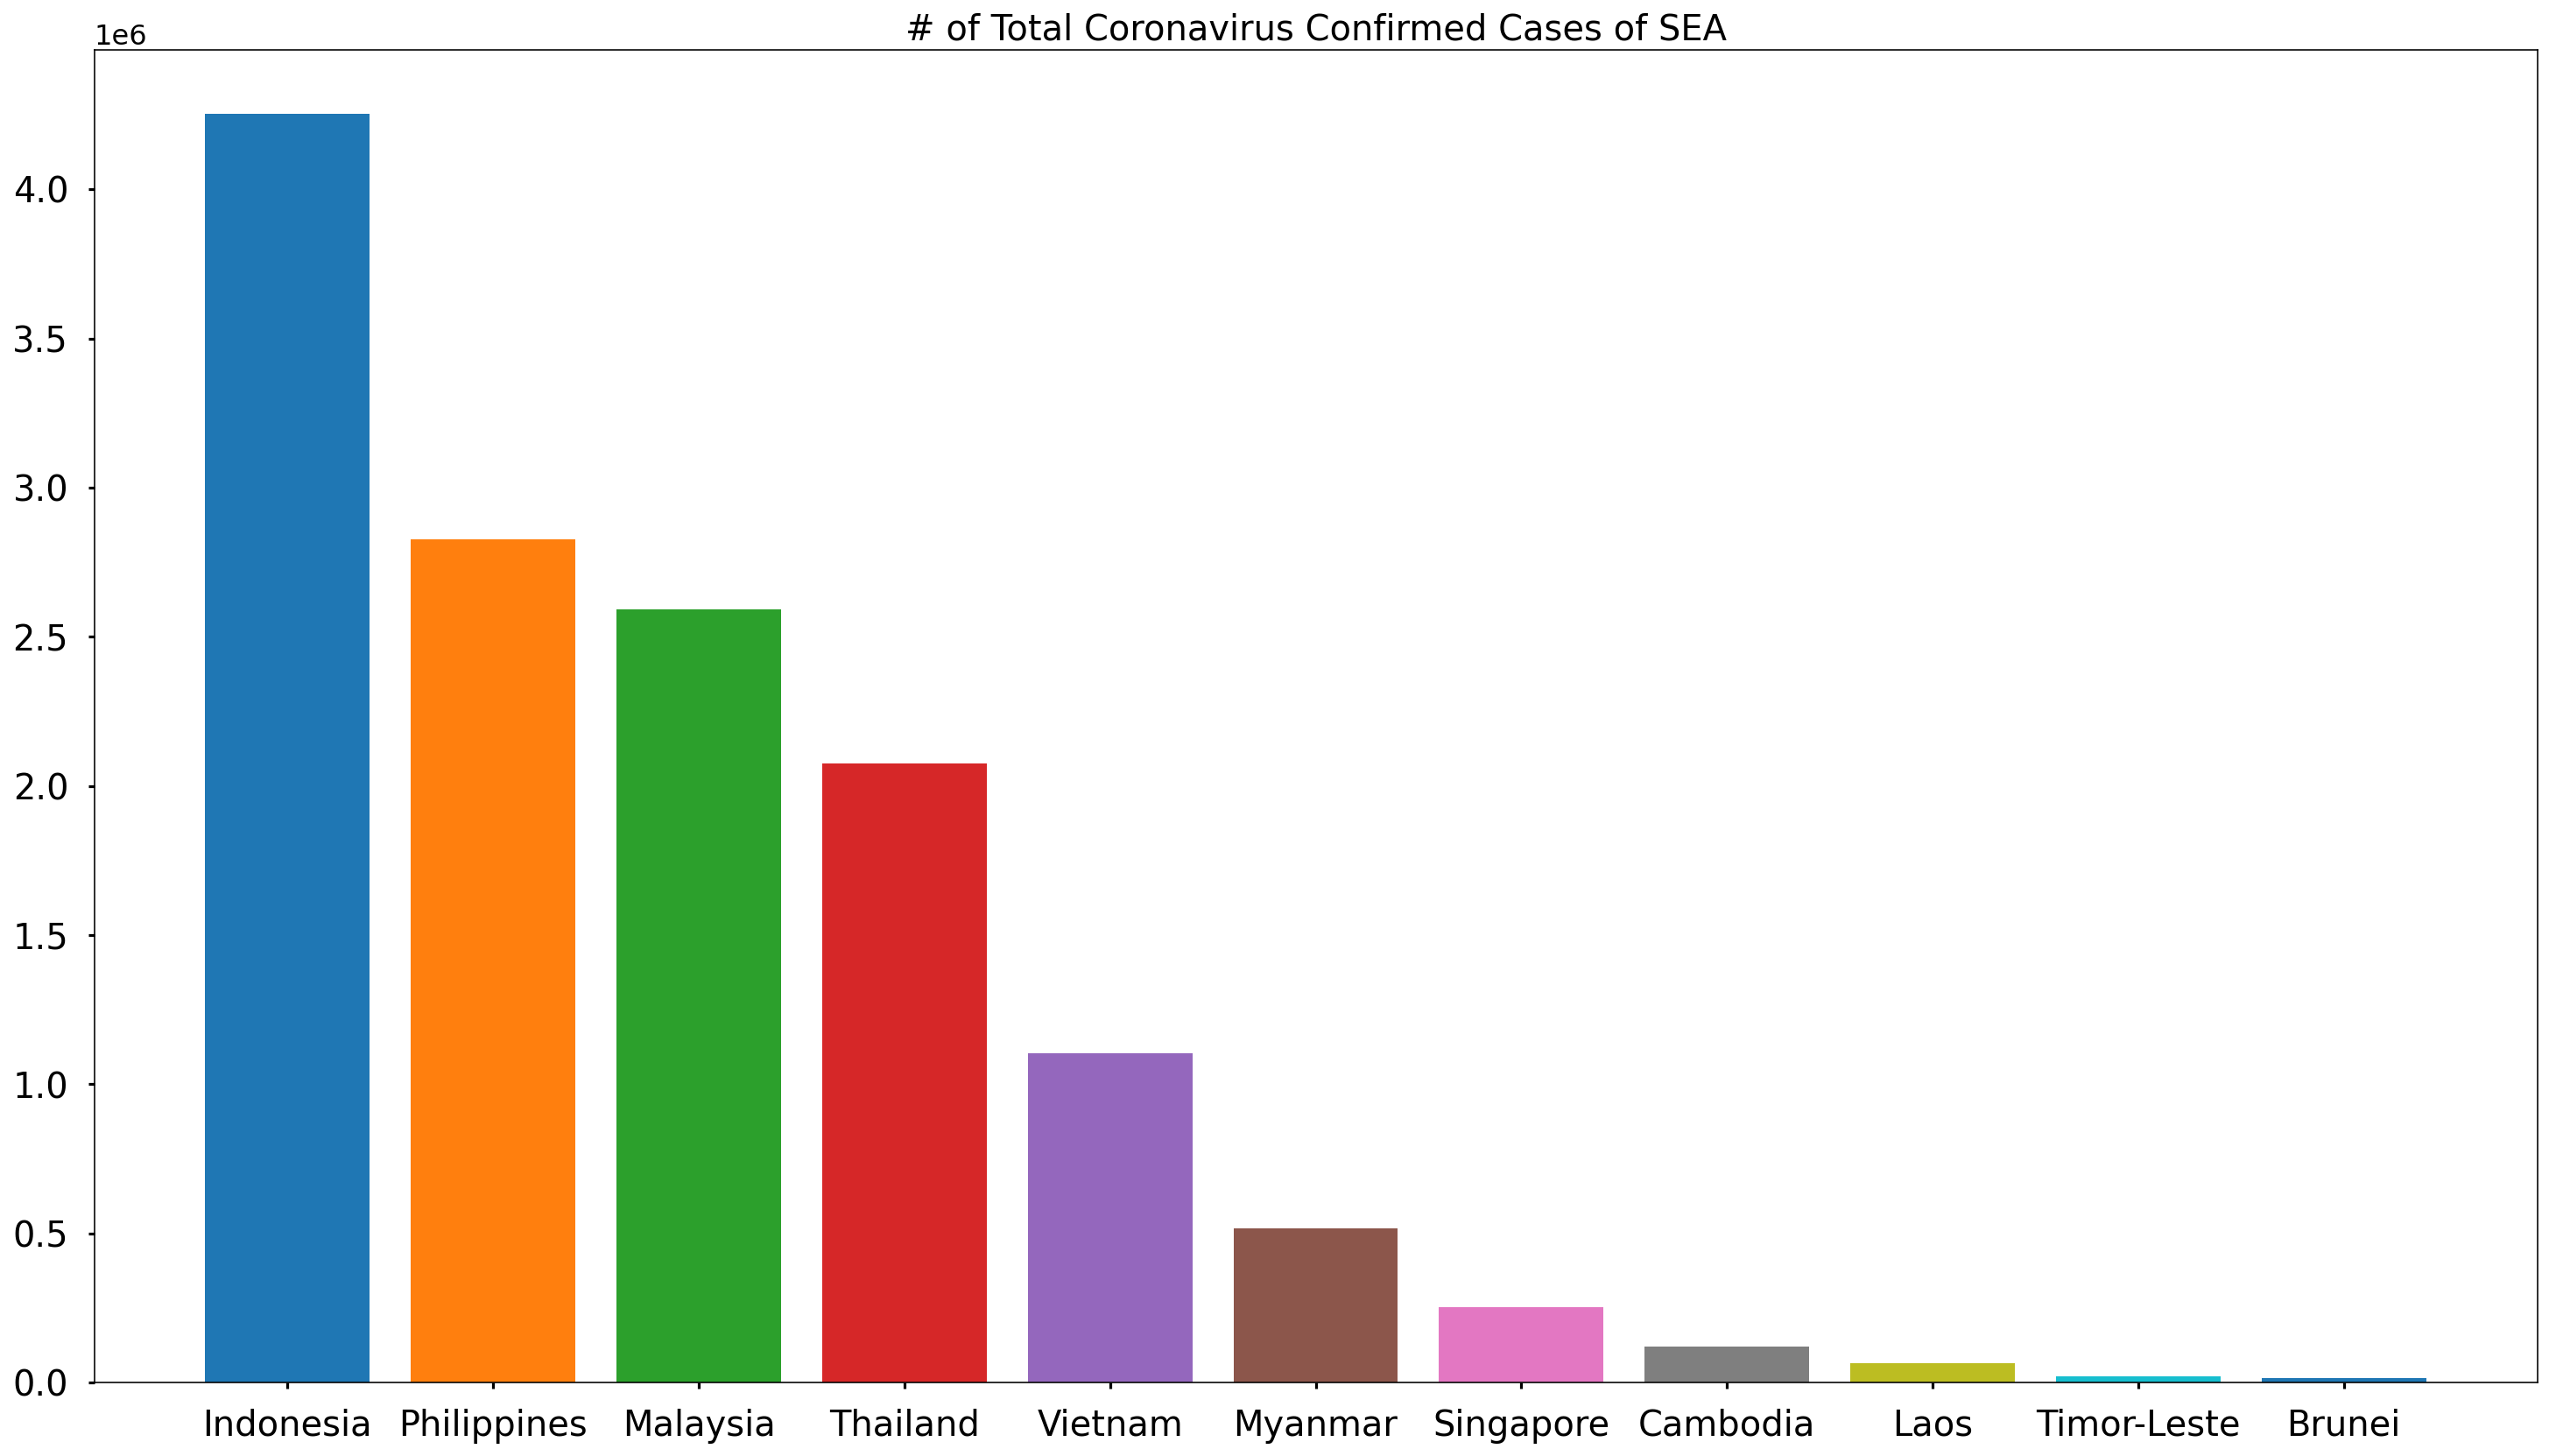

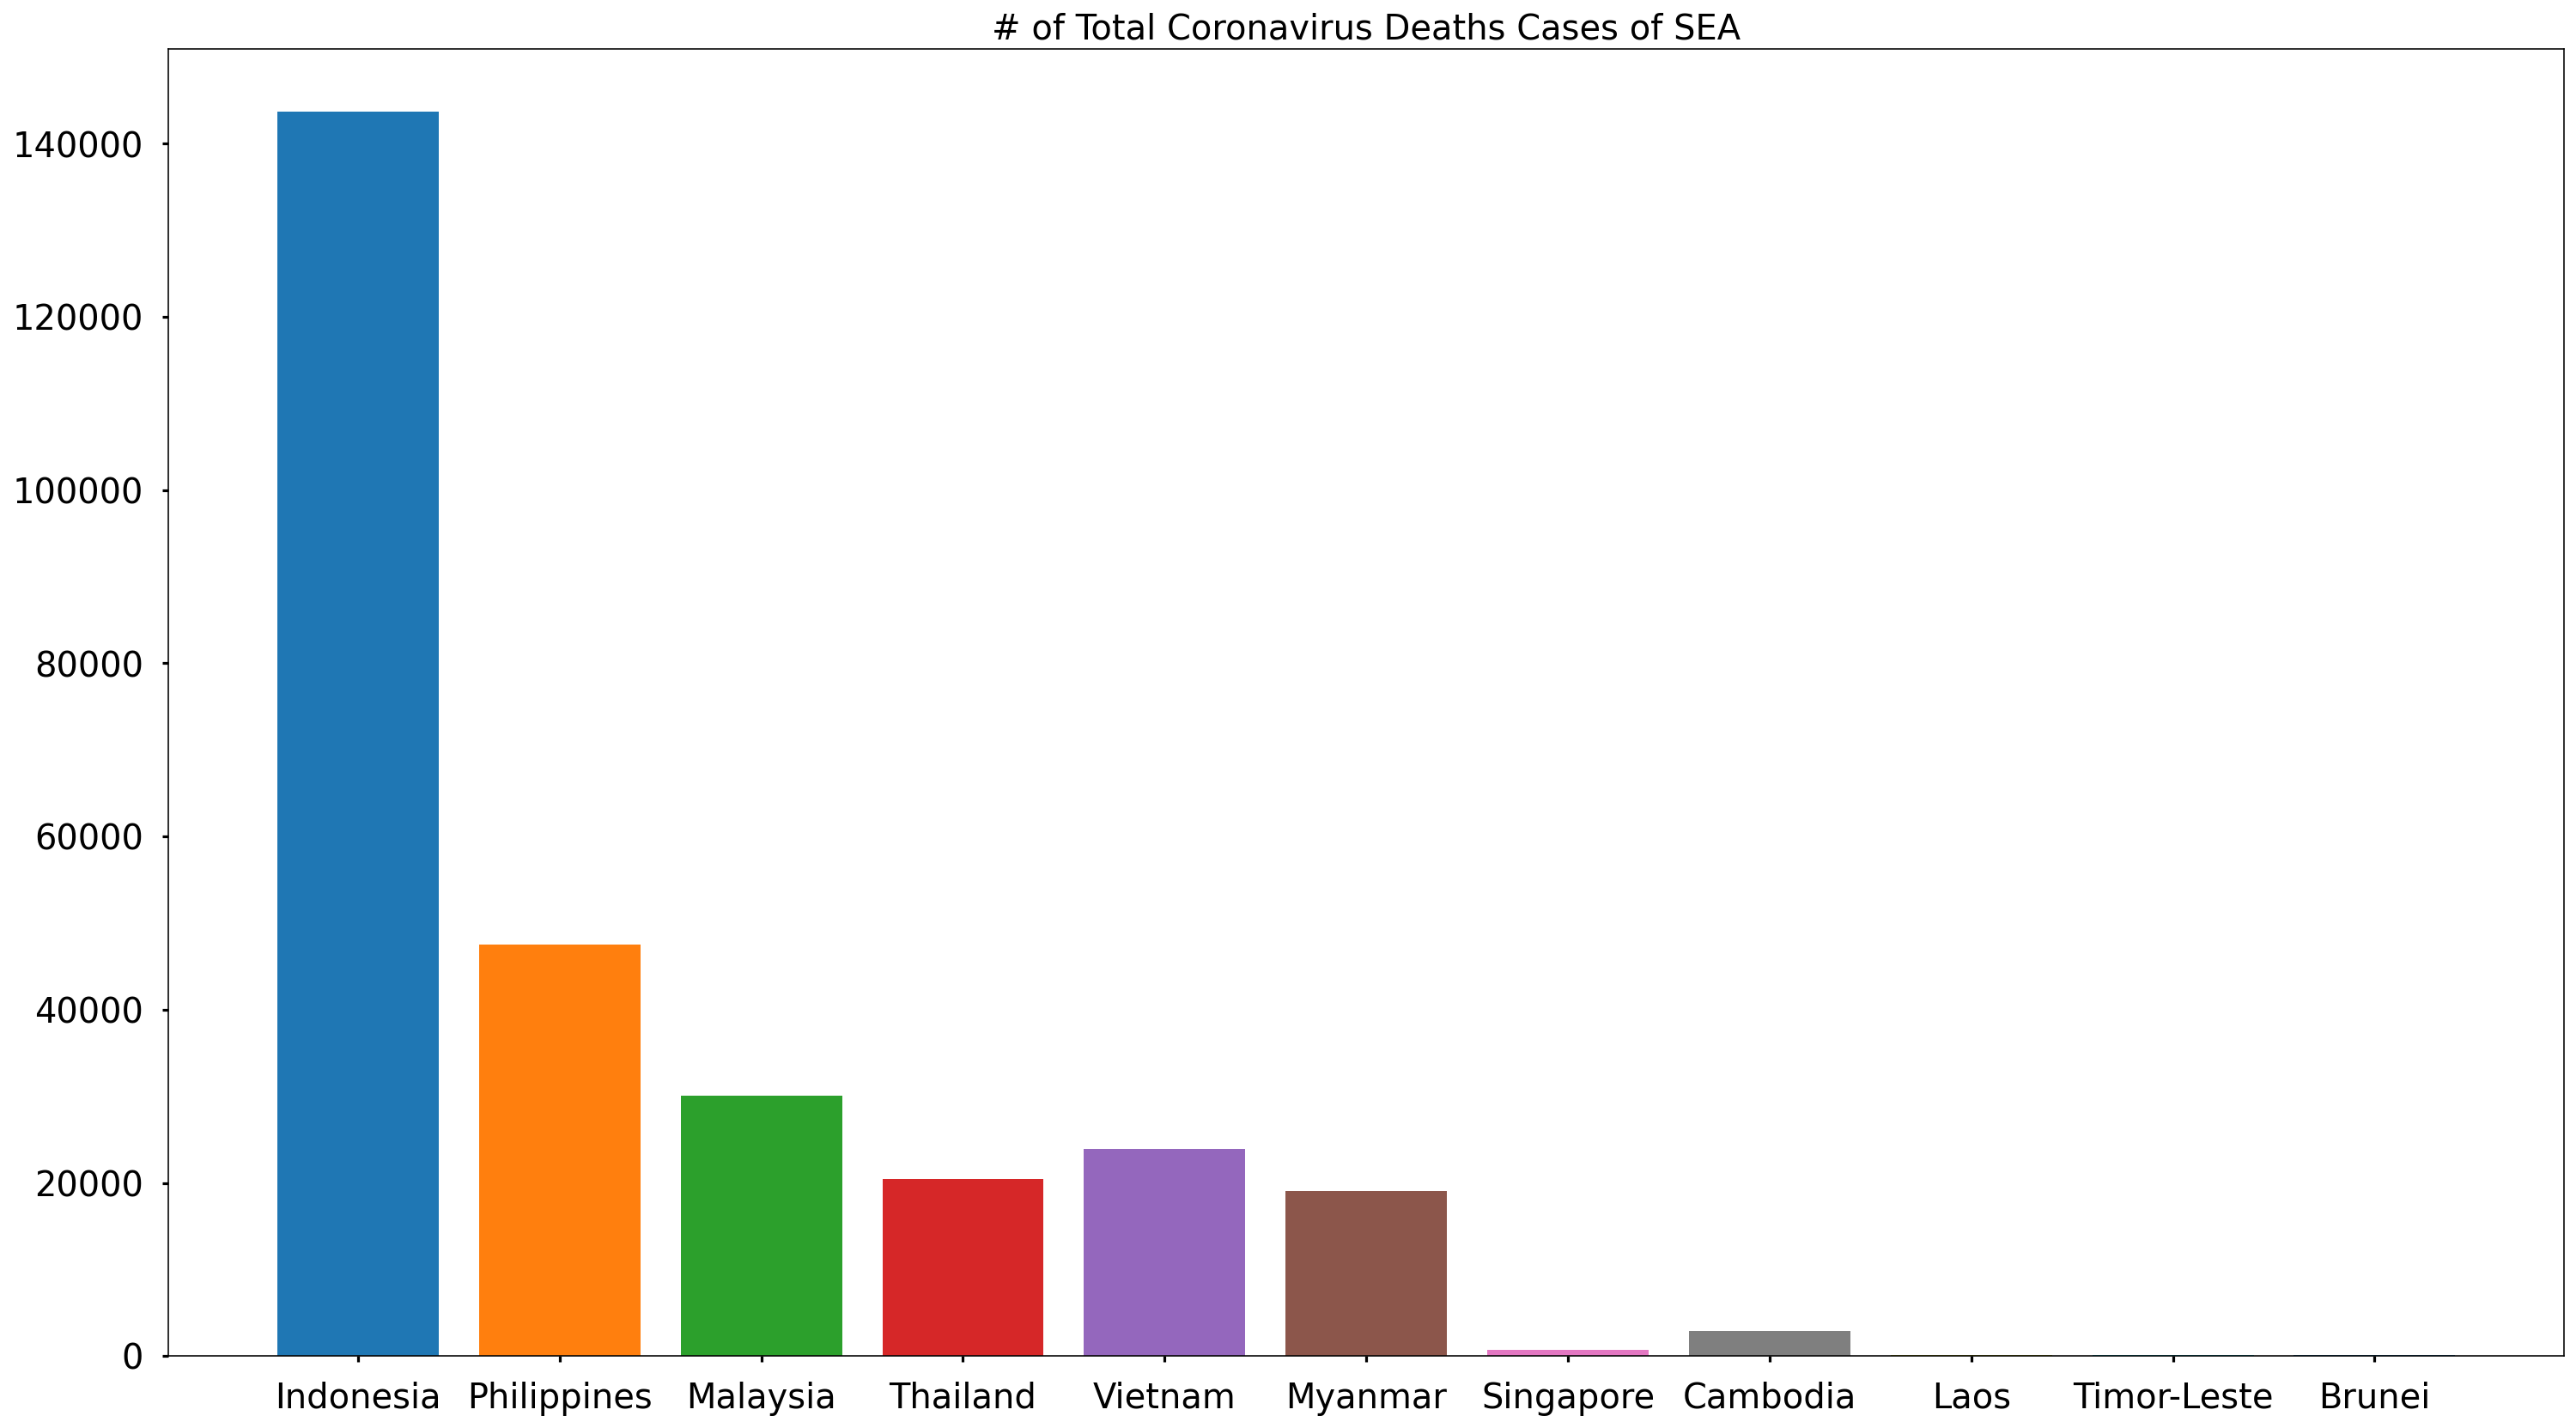

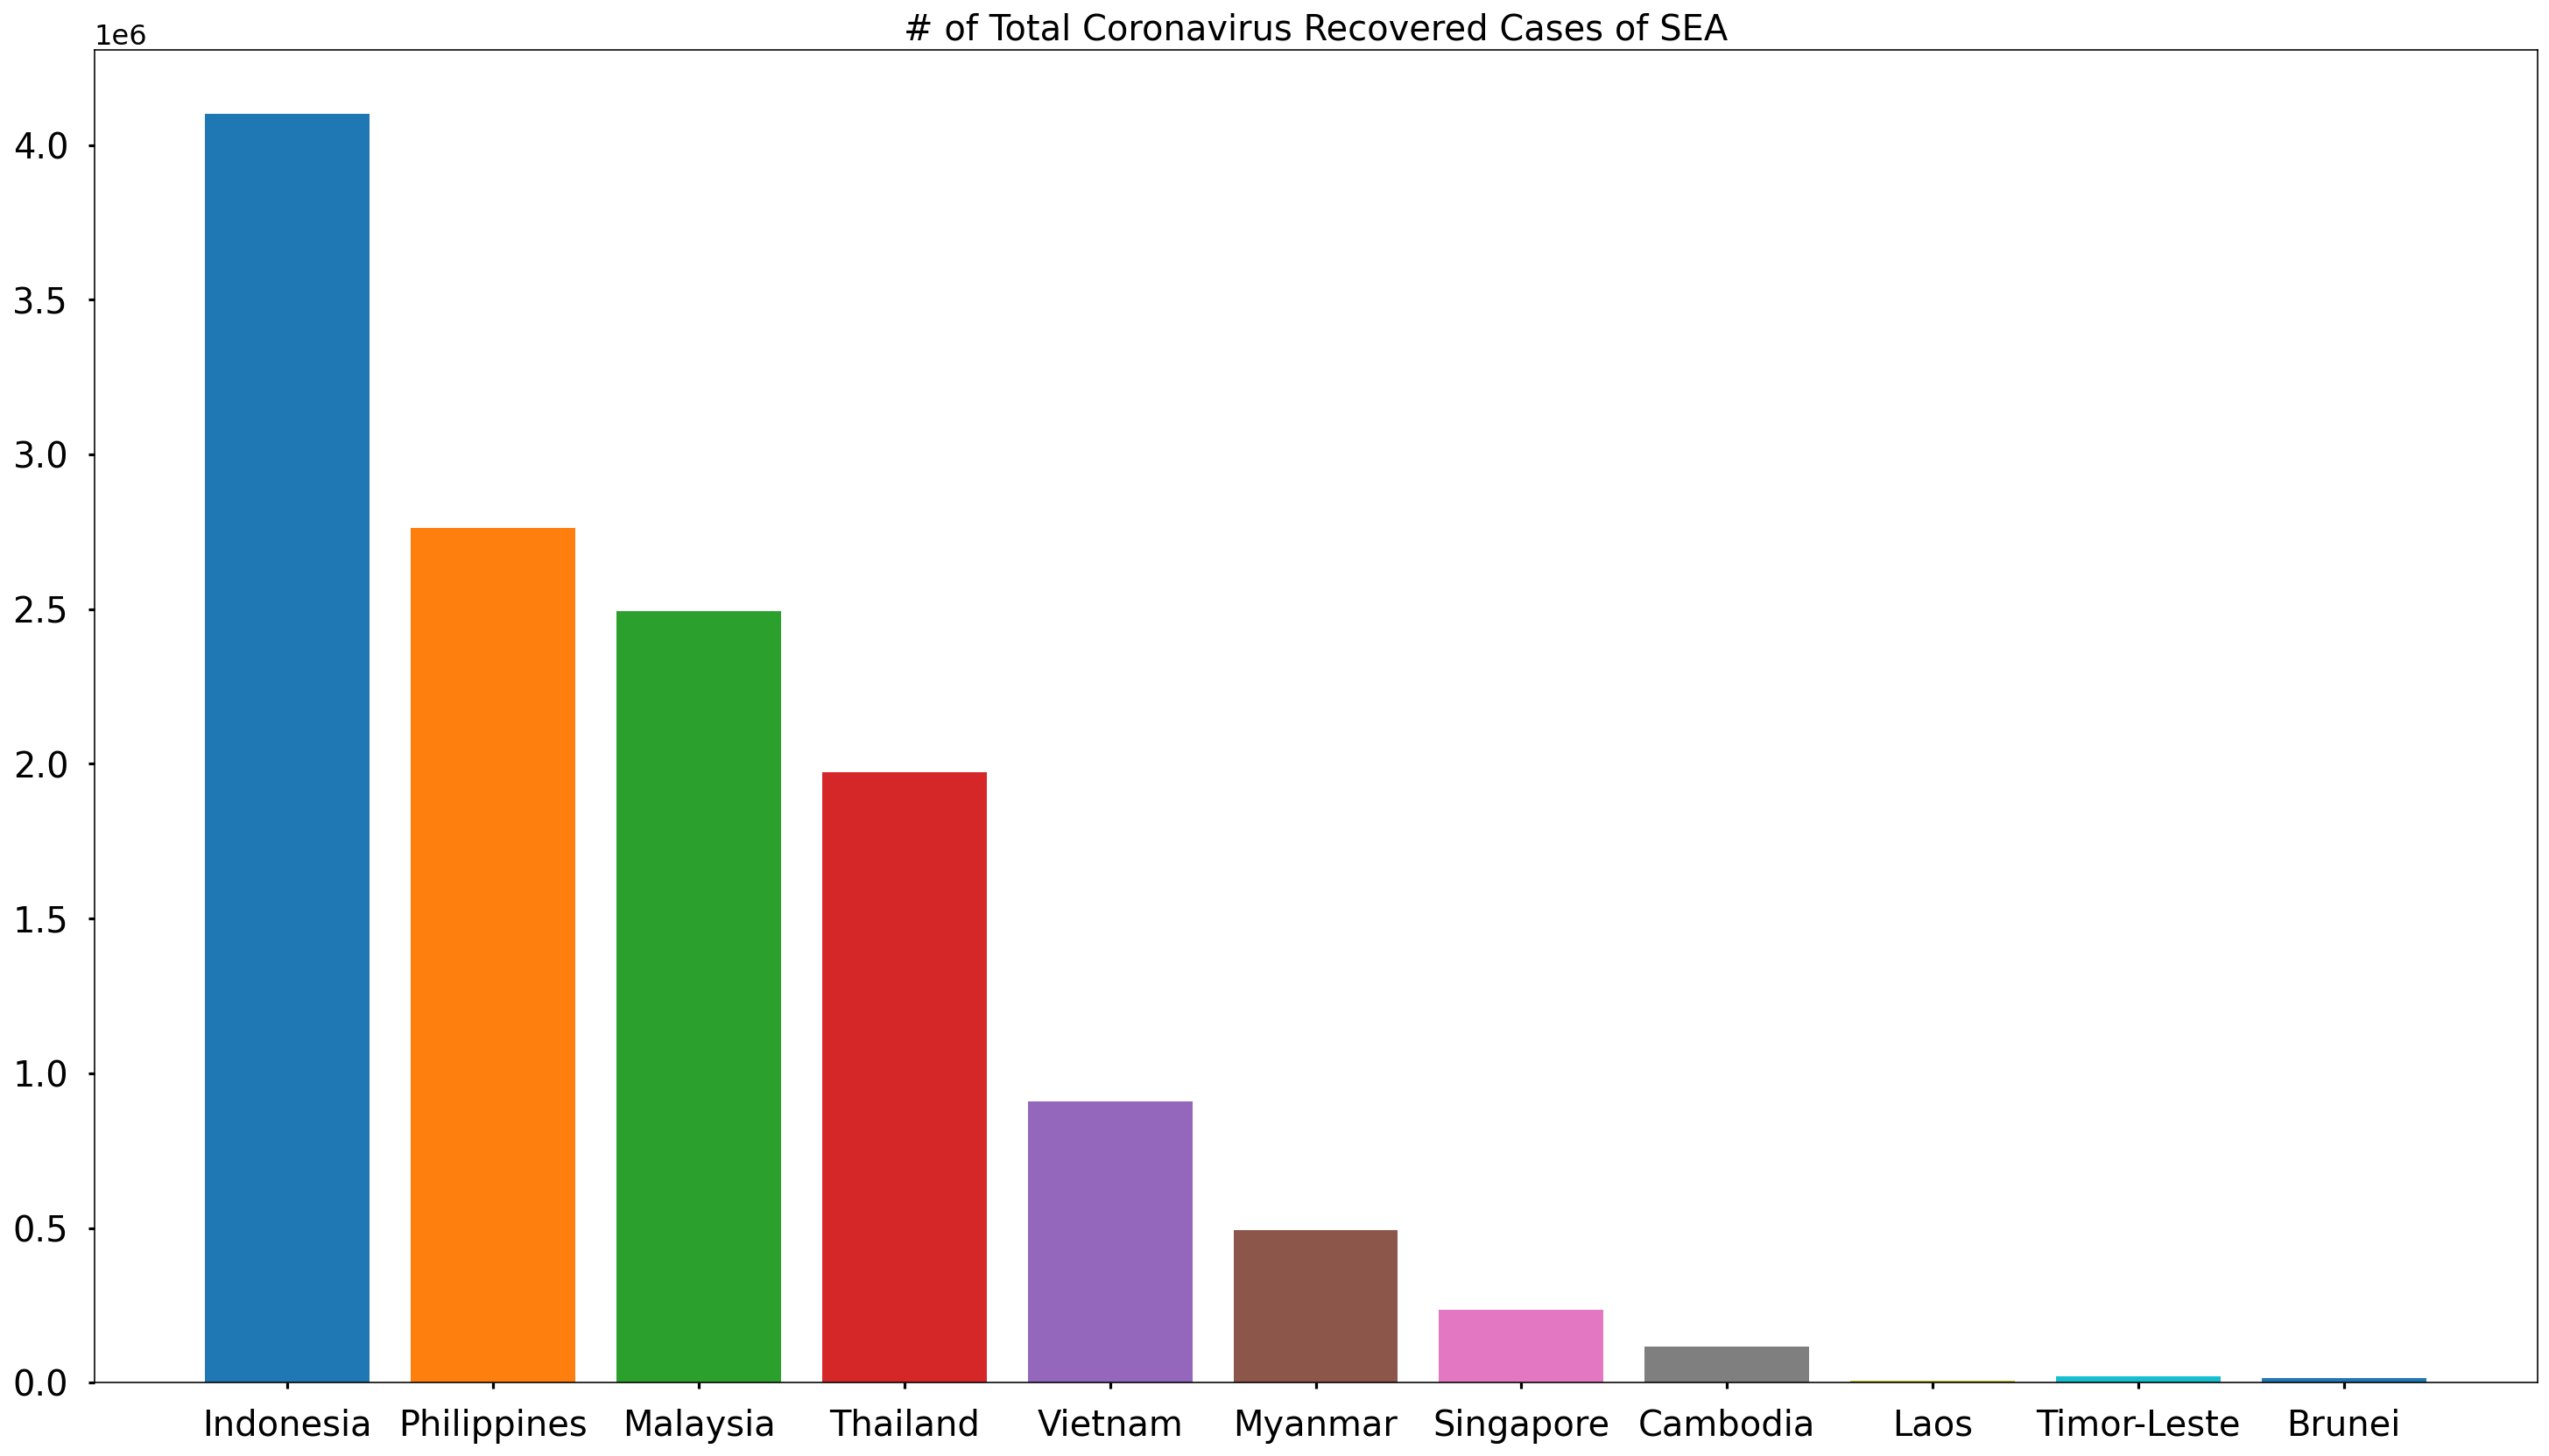

In [85]:
sum_country_sea = {}
for country in sea_countries:
    cases = sum_country[sum_country['NAME']==country]['TOTAL_CASES'].values[0]
    deaths = sum_country[sum_country['NAME']==country]['TOTAL_DEATHS'].values[0]
    recovered = sum_country[sum_country['NAME']==country]['TOTAL_RECOVERED'].values[0]
    sum_country_sea[country] = [cases, deaths, recovered]

sum_country_sea = dict(sorted(sum_country_sea.items(), key=lambda x: x[1], reverse=True))
### 3 bar chart to compare top 6 asia and vietnam in total case, deaths and recovered
plt.figure(figsize=(25, 14))
for key, item in sum_country_sea.items():
    plt.bar(key, item[0])
plt.title('# of Total Coronavirus Confirmed Cases of SEA', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(25, 14))
for key, item in sum_country_sea.items():
    plt.bar(key, item[1])
plt.title('# of Total Coronavirus Deaths Cases of SEA', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(25, 14))
for key, item in sum_country_sea.items():
    plt.bar(key, item[2])
plt.title('# of Total Coronavirus Recovered Cases of SEA', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()